In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

data = pd.read_csv("populations-sorted.csv")
# columns = ["Region, subregion, country or area *", "Year", "Type", "Total Population, as of 1 January (thousands)", "Total Population, as of 1 July (thousands)", "Male Population, as of 1 July (thousands)", "Female Population, as of 1 July (thousands)", "Median Age, as of 1 July (years)", "Population Change (thousands)", "Births (thousands)","Total Fertility Rate (live births per woman)", "Population Density, as of 1 July (persons per square km)", "Parent code", "Under-Five Mortality (deaths under age 5 per 1,000 live births)","Mortality before Age 40, both sexes (deaths under age 40 per 1,000 live births)","Net Number of Migrants (thousands)","Live Births Surviving to Age 1 (thousands)","Life Expectancy at Age 80, both sexes (years)","Total Deaths (thousands)","Life Expectancy at Birth, both sexes (years)","Sex Ratio at Birth (males per 100 female births)","Net Reproduction Rate (surviving daughters per woman)","Rate of Natural Change (per 1,000 population)","Population Growth Rate (percentage)","Births by women aged 15 to 19 (thousands)","Crude Birth Rate (births per 1,000 population)"]
# data = data[columns]
world_data = data[ data["Type"] == "World"]
region_data = data[data["Type"] == "SDG region"]
data = data[data["Type"] == "Country/Area"]
data = data.dropna()

# Random Forest grid search/crossvalidion using t-SNE with non-shuffled data

In [ ]:
# Assuming 'data' is a pandas DataFrame that has been previously defined
depths = [5, 10, 25, 50, 100, 200]
n_estimators = [5, 10, 50, 100, 200]
max_features = ["sqrt", "log2", None]
criteria = ['squared_error']

y = data["Total Population, as of 1 January (thousands)"]
X = data.drop([
    "Region, subregion, country or area *", 
    "Type", 
    "Variant",
    "Notes",
    "Location code",
    "ISO3 Alpha-code",
    "ISO2 Alpha-code",
    "SDMX code**",
    "Population Annual Doubling Time (years)",
    "Total Population, as of 1 January (thousands)", 
    "Total Population, as of 1 July (thousands)", 
    "Male Population, as of 1 July (thousands)", 
    "Female Population, as of 1 July (thousands)"
], axis=1)

# Standardize the numerical data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# Apply TSNE to reduce dimensions (e.g., to 2D)
tsne = TSNE(n_components=2, random_state=476, perplexity=30)
X_tsne = tsne.fit_transform(scaled_data)

# Now X_tsne is our transformed dataset
X_train, X_test, y_train, y_test = train_test_split(X_tsne, y, test_size=0.15, random_state=476, shuffle=False)

# Initialize a list to store the models and their cross-validation scores
best_models = []

# Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=False)

for depth in depths:
    for estimators in n_estimators:
        for features in max_features:
            for criterion in criteria:
                clf = RandomForestRegressor(
                    criterion=criterion, 
                    n_estimators=estimators, 
                    max_features=features, 
                    n_jobs=-1, 
                    max_depth=depth,
                    random_state=476
                )
                
                # Use cross_val_score with negative mean squared error
                # We'll convert it to RMSE later
                scores = cross_val_score(clf, X_train, y_train, 
                                         scoring='neg_mean_squared_error', 
                                         cv=kf, n_jobs=-1)
                # Convert negative MSE to RMSE
                rmse_scores = np.sqrt(-scores)
                avg_rmse = np.mean(rmse_scores)
                
                print(depth, estimators, features, criterion, "Avg RMSE:", avg_rmse)
                
                # Store the model parameters and average RMSE score
                best_models.append((depth, estimators, features, criterion, avg_rmse))

# Sort the models by average RMSE score
best_models.sort(key=lambda x: x[4])

# Select the top 8 models
top_models = best_models[:8]

# Create a DataFrame to display the top 8 models
columns = ["Depth", "Estimators", "Max Features", "Criterion", "RMSE"]
top_8_df = pd.DataFrame(top_models, columns=columns)
print(top_8_df)

# Refit the best model (lowest average RMSE) on the entire training set and evaluate on the test set
best_depth, best_estimators, best_features, best_criterion, best_cv_rmse = top_models[0]
best_model = RandomForestRegressor(
    criterion=best_criterion, 
    n_estimators=best_estimators, 
    max_features=best_features, 
    n_jobs=-1, 
    max_depth=best_depth,
    random_state=476
)
best_model.fit(X_train, y_train)
y_test_predict = best_model.predict(X_test)
test_score = root_mean_squared_error(y_test, y_test_predict)

print("Best parameters:", (best_depth, best_estimators, best_features, best_criterion))
print("Best RMSE (Cross-Validation):", best_cv_rmse) 
print("Test RMSE:", test_score)


# LSTM on non shuffled data

In [ ]:
# Standardize the numerical data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data for LSTM [samples, time steps, features]
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=476, shuffle=False)
X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=476, shuffle=False)

# Define the LSTM model
def create_model(units):
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_subtrain.shape[1], X_subtrain.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

units_list = [10, 50, 100, 200]
best_score = float('inf')
best_units = None

for units in units_list:
    model = create_model(units)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_subtrain, y_subtrain, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)
    y_val_predict = model.predict(X_val)
    score = root_mean_squared_error(y_val, y_val_predict)
    print(f"Units: {units}, Validation RMSE: {score}")
    if score < best_score:
        best_score = score
        best_units = units

# Output the best result
print("Best units:", best_units)
print("Best Validation RMSE:", best_score)

# Refit the best model on the entire training set and evaluate on the test set
best_model = create_model(best_units)
best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)
y_test_predict = best_model.predict(X_test)
test_score = root_mean_squared_error(y_test, y_test_predict)

print("Test RMSE:", test_score)

# Decision Tree using non-shuffled data

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Standardize the numerical data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=476, shuffle=False)
X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=476, shuffle=False)

best_score = float('inf')
best_params = None


for depth in depths:
    for criterion in criteria:
        clf = DecisionTreeRegressor(criterion=criterion, max_depth=depth)
        clf.fit(X_subtrain, y_subtrain)
        y_predict = clf.predict(X_val)
        score = root_mean_squared_error(y_val, y_predict)
        print(depth, criterion, score)
        # Update the best score and parameters if the current score is better
        if score < best_score:
            best_score = score
            best_params = (depth, criterion)

# Output the best result
print("Best parameters:", best_params)
print("Best RMSE:", best_score)

# Refit the model on the entire training set with the best parameters
best_depth, best_criterion = best_params
best_model = DecisionTreeRegressor(criterion=best_criterion, max_depth=best_depth)
best_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_test_predict = best_model.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_test_predict)

print("Test RMSE of the best model:", test_rmse)


In [ ]:
depths = [2, 5, 10,25, 50, 100, 200, 500]
n_estimators = [5, 10, 50, 100, 200, 500]
max_features = ["sqrt", "log2", None]
criteria = ['squared_error', "friedman_mse", "poisson"]

best_score = float('inf')
best_params = None


for depth in depths:
    for estimators in n_estimators:
        for features in max_features:
            for criterion in criteria: 
                clf = RandomForestRegressor(criterion=criterion, n_estimators=estimators, max_features=features, n_jobs=-1, max_depth=depth)
                clf.fit(X_subtrain, y_subtrain)
                y_predict = clf.predict(X_val)
                score = root_mean_squared_error(y_val, y_predict)
                print(depth, estimators, features,criterion, score)
                # Update the best score and parameters if the current score is better
                if score < best_score:
                    best_score = score
                    best_params = (depth, estimators, features, criterion)

# Output the best result
print("Best parameters:", best_params)
print("Best RMSE:", best_score)

# Refit the best model on the entire training set and evaluate on the test set
best_depth, best_estimators, best_features, best_criterion = best_params
best_model = RandomForestRegressor(criterion=best_criterion, n_estimators=best_estimators, max_features=best_features, n_jobs=-1, max_depth=best_depth)
best_model.fit(X_train, y_train)
y_test_predict = best_model.predict(X_test)
test_score = root_mean_squared_error(y_test, y_test_predict)

print("Test RMSE:", test_score)

# Random Forest using shuffled data

In [ ]:
depths = [2, 5, 10,25, 50, 100, 200, 500]
n_estimators = [5, 10, 50, 100, 200, 500]
max_features = ["sqrt", "log2", None]
criteria = ['squared_error', "friedman_mse", "poisson"]
# Standardize the numerical data
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=476,)
X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=476)


best_score = float('inf')
best_params = None


for depth in depths:
    for estimators in n_estimators:
        for features in max_features:
            for criterion in criteria: 
                clf = RandomForestRegressor(criterion=criterion, n_estimators=estimators, max_features=features, n_jobs=-1, max_depth=depth)
                clf.fit(X_subtrain, y_subtrain)
                y_predict = clf.predict(X_val)
                score = root_mean_squared_error(y_val, y_predict)
                print(depth, estimators, features,criterion, score)
                # Update the best score and parameters if the current score is better
                if score < best_score:
                    best_score = score
                    best_params = (depth, estimators, features, criterion)

# Output the best result
print("Best parameters:", best_params)
print("Best RMSE:", best_score)

# Refit the best model on the entire training set and evaluate on the test set
best_depth, best_estimators, best_features, best_criterion = best_params
best_model = RandomForestRegressor(criterion=best_criterion, n_estimators=best_estimators, max_features=best_features, n_jobs=-1, max_depth=best_depth)
best_model.fit(X_train, y_train)
y_test_predict = best_model.predict(X_test)
test_score = root_mean_squared_error(y_test, y_test_predict)

print("Test RMSE:", test_score)

# t-SNE visualization of dataset with color coding

In [ ]:
def categorize_growth_rate(row):
    growth_rate = row['Population Growth Rate (percentage)']
    if growth_rate > 2:
        return 'High Growth'
    elif 0.5 < growth_rate <= 2:
        return 'Low Growth'
    elif -0.2 <= growth_rate <= 0.5:
        return 'Stagnant'
    else:
        return 'Decreasing'

# Filter the DataFrame for the year 2023
# X_subtrain = X[X['Year].copy()

# Apply the categorization function
X_subtrain['Growth Category'] = X_subtrain.apply(categorize_growth_rate, axis=1)

# Define the numerical columns
numerical_columns = [
    "Population Density, as of 1 July (persons per square km)",
    "Population Sex Ratio, as of 1 July (males per 100 females)",
    "Median Age, as of 1 July (years)",
    "Natural Change, Births minus Deaths (thousands)",
    "Rate of Natural Change (per 1,000 population)",
    "Population Change (thousands)",
    "Population Growth Rate (percentage)",
    "Births (thousands)",
    "Births by women aged 15 to 19 (thousands)",
    "Crude Birth Rate (births per 1,000 population)",
    "Total Fertility Rate (live births per woman)",
    "Net Reproduction Rate (surviving daughters per woman)",
    "Mean Age Childbearing (years)",
    "Sex Ratio at Birth (males per 100 female births)",
    "Total Deaths (thousands)",
    "Male Deaths (thousands)",
    "Female Deaths (thousands)",
    "Crude Death Rate (deaths per 1,000 population)",
    "Life Expectancy at Birth, both sexes (years)",
    "Male Life Expectancy at Birth (years)",
    "Female Life Expectancy at Birth (years)",
    "Life Expectancy at Age 15, both sexes (years)",
    "Male Life Expectancy at Age 15 (years)",
    "Female Life Expectancy at Age 15 (years)",
    "Life Expectancy at Age 65, both sexes (years)",
    "Male Life Expectancy at Age 65 (years)",
    "Female Life Expectancy at Age 65 (years)",
    "Life Expectancy at Age 80, both sexes (years)",
    "Male Life Expectancy at Age 80 (years)",
    "Female Life Expectancy at Age 80 (years)",
    "Infant Deaths, under age 1 (thousands)",
    "Infant Mortality Rate (infant deaths per 1,000 live births)",
    "Live Births Surviving to Age 1 (thousands)",
    "Under-Five Deaths, under age 5 (thousands)",
    "Under-Five Mortality (deaths under age 5 per 1,000 live births)",
    "Mortality before Age 40, both sexes (deaths under age 40 per 1,000 live births)",
    "Male Mortality before Age 40 (deaths under age 40 per 1,000 male live births)",
    "Female Mortality before Age 40 (deaths under age 40 per 1,000 female live births)",
    "Mortality before Age 60, both sexes (deaths under age 60 per 1,000 live births)",
    "Male Mortality before Age 60 (deaths under age 60 per 1,000 male live births)",
    "Female Mortality before Age 60 (deaths under age 60 per 1,000 female live births)",
    "Mortality between Age 15 and 50, both sexes (deaths under age 50 per 1,000 alive at age 15)",
    "Male Mortality between Age 15 and 50 (deaths under age 50 per 1,000 males alive at age 15)",
    "Female Mortality between Age 15 and 50 (deaths under age 50 per 1,000 females alive at age 15)",
    "Mortality between Age 15 and 60, both sexes (deaths under age 60 per 1,000 alive at age 15)",
    "Male Mortality between Age 15 and 60 (deaths under age 60 per 1,000 males alive at age 15)",
    "Female Mortality between Age 15 and 60 (deaths under age 60 per 1,000 females alive at age 15)",
    "Net Number of Migrants (thousands)",
    "Net Migration Rate (per 1,000 population)"
]

# Extract the numerical data
numerical_data = X_subtrain.drop(['Growth Category'], axis=1)

# # Standardize the numerical data
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(numerical_data)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(numerical_data)

# Add the t-SNE results to the DataFrame
X_subtrain.loc[:, 'tsne-2d-one'] = tsne_results[:, 0]
X_subtrain.loc[:, 'tsne-2d-two'] = tsne_results[:, 1]

# Define the color map
category_colors = {
    'Decreasing': 'red',
    'Stagnant': 'yellow',
    'Low Growth': 'lightgreen',
    'High Growth': 'darkgreen'
}

# Map the colors to the growth categories
colors = X_subtrain['Growth Category'].map(category_colors)

# Visualize the results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_subtrain['tsne-2d-one'], X_subtrain['tsne-2d-two'], 
    c=colors, alpha=0.7
)
# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in category_colors.values()]
labels = category_colors.keys()
plt.legend(handles, labels, title="Growth Category")

plt.title("t-SNE Visualization of Population Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


# Experiment 2: Population Projection
# Use Random Forest and a Linear Regression to project the population changes between 2000 and 2023

# Projection without t-SNE or scaling

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming 'data' is a pandas DataFrame
actual = data[data['Year'] > 2000]
s_data = data[data['Year'] <= 2001]

def fit_linear_trend(data, country):
    # Fit a linear model to the annual population changes
    country_data = data[data['Region, subregion, country or area *'] == country]
    years = np.arange(len(country_data)).reshape(-1, 1)
    annual_changes = country_data['Population Change (thousands)']

    model = LinearRegression()
    model.fit(years, annual_changes)
    return model

def project_population_with_trend(data, country, years_to_project):
    # Get the most recent population data for the specified country
    latest_population_data = data[data['Region, subregion, country or area *'] == country]
    current_population = latest_population_data['Total Population, as of 1 January (thousands)'].iloc[-1]

    # Fit a linear trend model to the historical data
    model = fit_linear_trend(data, country)

    # Initialize a list to store the projected populations
    future_populations = [current_population]

    # Calculate the population for each future year
    for year in range(1, years_to_project + 1):
        # Predict the annual increase for the year
        year_index = len(latest_population_data) + year - 1
        annual_increase = model.predict([[year_index]])

        # Calculate the population for the year and add it to the list
        next_year_population = future_populations[-1] + annual_increase[0]
        future_populations.append(next_year_population)

    return future_populations

def fit_random_forest(data, country):
    # Fit a Random Forest model to the annual population changes
    country_data = data[data['Region, subregion, country or area *'] == country]
    years = np.arange(len(country_data)).reshape(-1, 1)
    annual_changes = country_data['Population Change (thousands)']

    model = RandomForestRegressor(n_estimators=50, random_state=476, max_depth=25, max_features=None)
    model.fit(years, annual_changes)
    return model

def project_population_with_random_forest(data, country, years_to_project):
    # Get the most recent population data for the specified country
    latest_population_data = data[data['Region, subregion, country or area *'] == country]
    current_population = latest_population_data['Total Population, as of 1 January (thousands)'].iloc[-1]

    # Fit a Random Forest model to the historical data
    model = fit_random_forest(data, country)

    # Initialize a list to store the projected populations
    future_populations = [current_population]

    # Calculate the population for each future year
    for year in range(1, years_to_project + 1):
        # Predict the annual increase for the year
        year_index = len(latest_population_data) + year - 1
        annual_increase = model.predict([[year_index]])

        # Calculate the population for the year and add it to the list
        next_year_population = future_populations[-1] + annual_increase[0]
        future_populations.append(next_year_population)

    return future_populations

projection_length = 50
countries = s_data['Region, subregion, country or area *'].unique()
# countries = ["Azerbaijan"]
for country in countries:
    projected_populations_linear = project_population_with_trend(s_data, country, projection_length)
    projected_populations_rf = project_population_with_random_forest(s_data, country, projection_length)
    
    plt.plot(range(2001, 2002 + projection_length), projected_populations_linear, label='Projected Linear', color = "green")
    plt.plot(range(2001, 2002 + projection_length), projected_populations_rf, label='Projected RF', color="blue")
    plt.title(f"{country} Population over next {projection_length} Years")
    plt.ylabel("Population in thousands")
    plt.xlabel("Year")
    
    country_data = s_data[s_data['Region, subregion, country or area *'] == country]
    years = country_data["Year"]
    population = country_data["Total Population, as of 1 January (thousands)"]
    plt.plot(years, population, label='Historical')
    
    country_actual = actual[actual['Region, subregion, country or area *'] == country]
    plt.plot(country_actual['Year'], country_actual["Total Population, as of 1 January (thousands)"], color='red', label='Actual')
    
    # Calculate RMSE for the years where actual data is available
    actual_years = range(2000, 2023)
    actual_populations = country_actual["Total Population, as of 1 January (thousands)"].values
    predicted_populations_linear = projected_populations_linear[:len(actual_years)]
    predicted_populations_rf = projected_populations_rf[:len(actual_years)]
    
    rmse_linear = np.sqrt(mean_squared_error(actual_populations, predicted_populations_linear))
    rmse_rf = np.sqrt(mean_squared_error(actual_populations, predicted_populations_rf))
    print(f"{country} Linear RMSE: {rmse_linear}")
    print(f"{country} RF RMSE: {rmse_rf}")
    
    plt.legend()
    plt.show()
    plt.close()

This section does the previous techniques on data transformed using tSNE

In [ ]:
data = pd.read_csv("populations-sorted.csv")
columns = ["Region, subregion, country or area *", "Year", "Type", "Total Population, as of 1 January (thousands)", "Total Population, as of 1 July (thousands)", "Male Population, as of 1 July (thousands)", "Female Population, as of 1 July (thousands)", "Median Age, as of 1 July (years)", "Population Change (thousands)", "Births (thousands)","Total Fertility Rate (live births per woman)", "Population Density, as of 1 July (persons per square km)", "Parent code", "Under-Five Mortality (deaths under age 5 per 1,000 live births)","Mortality before Age 40, both sexes (deaths under age 40 per 1,000 live births)","Net Number of Migrants (thousands)","Live Births Surviving to Age 1 (thousands)","Life Expectancy at Age 80, both sexes (years)","Total Deaths (thousands)","Life Expectancy at Birth, both sexes (years)","Sex Ratio at Birth (males per 100 female births)","Net Reproduction Rate (surviving daughters per woman)","Rate of Natural Change (per 1,000 population)","Population Growth Rate (percentage)","Births by women aged 15 to 19 (thousands)","Crude Birth Rate (births per 1,000 population)"]
data = data[columns]
world_data = data[ data["Type"] == "World"]
region_data = data[data["Type"] == "SDG region"]
data = data[data["Type"] == "Country/Area"]
# data = data[data["Region, subregion, country or area *"] == "Azerbaijan"]
data = data.dropna()
# y = data["Total Population, as of 1 January (thousands)"]
# X = data.drop(["Region, subregion, country or area *", "Type","Total Population, as of 1 January (thousands)", "Total Population, as of 1 July (thousands)","Male Population, as of 1 July (thousands)", "Female Population, as of 1 July (thousands)"], axis=1)

# # Standardize the numerical data
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(X)

# # Apply t-SNE
# tsne = TSNE(n_components=3, random_state=42, perplexity=30)
# tsne_results = tsne.fit_transform(scaled_data)



# X_train, X_test, y_train, y_test = train_test_split(tsne_results, y, test_size=0.2, random_state=476, shuffle=False)
# X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=476, shuffle=False)

In [ ]:
errors = []
years = []
# data = data[data["Region, subregion, country or area *"] == "Azerbaijan"]
for i in range(1951, 2024):
    train = data[data['Year'] < i]
    test = data[data['Year'] >= i]

    y_train = train["Total Population, as of 1 January (thousands)"]
    X_train = train.drop(["Region, subregion, country or area *", "Type","Total Population, as of 1 January (thousands)", "Total Population, as of 1 July (thousands)","Male Population, as of 1 July (thousands)", "Female Population, as of 1 July (thousands)"], axis=1)
    y_test = test["Total Population, as of 1 January (thousands)"]
    X_test = test.drop(["Region, subregion, country or area *", "Type","Total Population, as of 1 January (thousands)", "Total Population, as of 1 July (thousands)","Male Population, as of 1 July (thousands)", "Female Population, as of 1 July (thousands)"], axis=1)

    clf = RandomForestRegressor(n_estimators=50, max_features="sqrt", n_jobs=-1, max_depth=25)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    score = root_mean_squared_error(y_test, y_predict)
    errors.append(score)
    years.append(i)


plt.plot(years, errors)
plt.xlabel("Cutoff Year")
plt.ylabel("RMSE")
plt.title("Error At Predicting Future Population by Cutoff Year")

# Projection using t-SNE and scaling

C:\Users\justi\AppData\Local\Temp\ipykernel_14460\1572409710.py:11: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("populations-sorted.csv")


Germany Linear RMSE: 1047.2475206719264
Germany RF RMSE: 2010.0180465808846


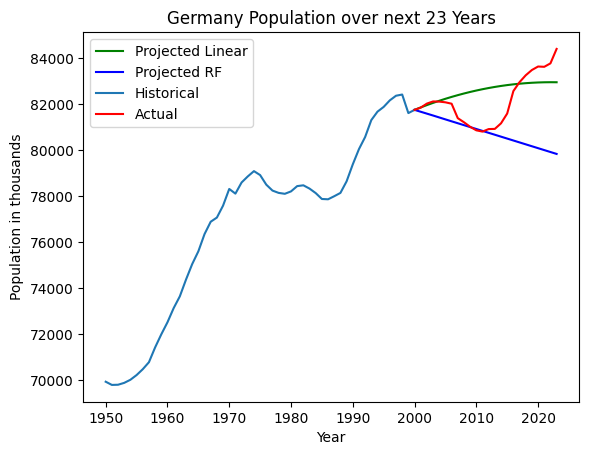

Ukraine Linear RMSE: 1783.1023305683211
Ukraine RF RMSE: 2652.8060462782823


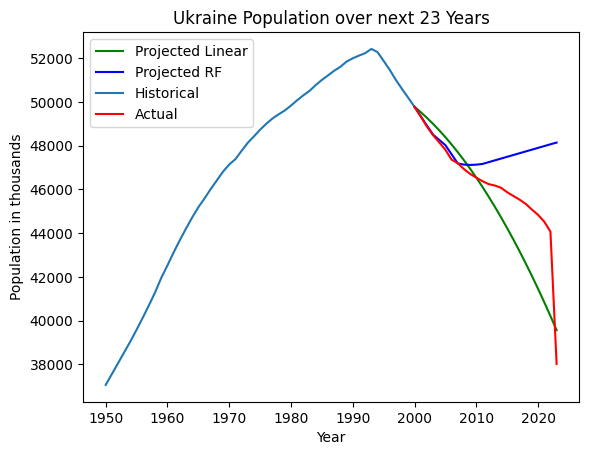

Azerbaijan Linear RMSE: 59.95295474470835
Azerbaijan RF RMSE: 340.5369191725334


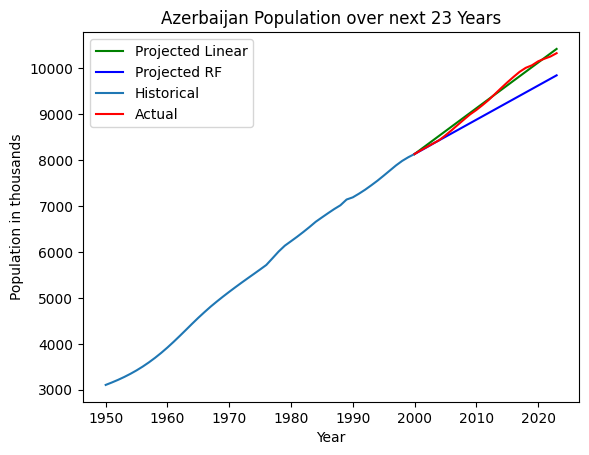

Average Linear Regression RMSE: 963.4342686616519
Average Random Forest RMSE: 1667.7870040105665
better_model
Linear    3
dtype: int64


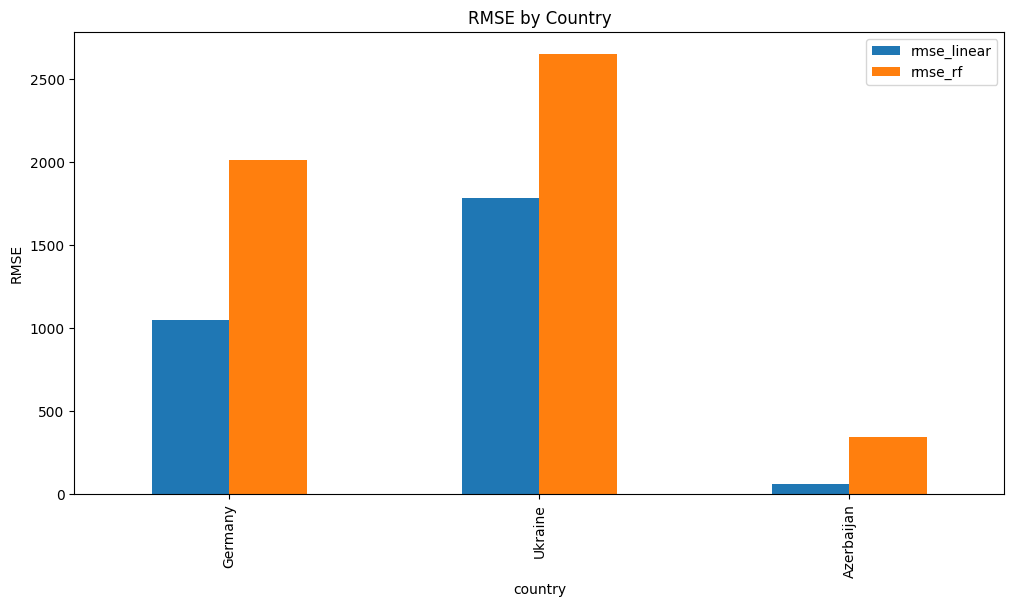

Random Forest RMSE:  1931.6243475437082
Linear Regression RMSE:  1194.4002187449978


In [53]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


data = pd.read_csv("populations-sorted.csv")
# columns = ["Region, subregion, country or area *", "Year", "Type", "Total Population, as of 1 January (thousands)", "Total Population, as of 1 July (thousands)", "Male Population, as of 1 July (thousands)", "Female Population, as of 1 July (thousands)", "Median Age, as of 1 July (years)", "Population Change (thousands)", "Births (thousands)","Total Fertility Rate (live births per woman)", "Population Density, as of 1 July (persons per square km)", "Parent code", "Under-Five Mortality (deaths under age 5 per 1,000 live births)","Mortality before Age 40, both sexes (deaths under age 40 per 1,000 live births)","Net Number of Migrants (thousands)","Live Births Surviving to Age 1 (thousands)","Life Expectancy at Age 80, both sexes (years)","Total Deaths (thousands)","Life Expectancy at Birth, both sexes (years)","Sex Ratio at Birth (males per 100 female births)","Net Reproduction Rate (surviving daughters per woman)","Rate of Natural Change (per 1,000 population)","Population Growth Rate (percentage)","Births by women aged 15 to 19 (thousands)","Crude Birth Rate (births per 1,000 population)"]
# data = data[columns]
world_data = data[ data["Type"] == "World"]
region_data = data[data["Type"] == "SDG region"]
data = data[data["Type"] == "Country/Area"]
data = data.drop([
    "Type", 
    "Variant",
    "Notes",
    "Location code",
    "ISO3 Alpha-code",
    "ISO2 Alpha-code",
    "SDMX code**",
    "Population Annual Doubling Time (years)",
], axis=1)

data = data.dropna()

results = []

total_projection_rf = []
total_projection_ln = []
total_actual = []
# Assuming 'data' is a pandas DataFrame
actual_data = data[data['Year'] >= 2000]
historical_data = data[data['Year'] <= 2000]

def fit_linear_trend(data, country):
    country_data = data[data['Region, subregion, country or area *'] == country].copy()
    years = np.arange(len(country_data)).reshape(-1, 1)
    annual_changes = country_data['Population Change (thousands)'].values

    model = LinearRegression()
    model.fit(years, annual_changes)
    return model

def project_population_with_trend(data, country, years_to_project):
    # print(country)
    latest_population_data = data[data['Region, subregion, country or area *'] == country].copy()
    # print(latest_population_data)
    current_population = latest_population_data['Total Population, as of 1 January (thousands)'].iloc[-1]

    model = fit_linear_trend(data, country)

    future_populations = [current_population]
    for year in range(1, years_to_project + 1):
        year_index = len(latest_population_data) + year - 1
        annual_increase = model.predict([[year_index]])
        next_year_population = future_populations[-1] + annual_increase[0]
        future_populations.append(next_year_population)

    return future_populations

def train_random_forest_with_tsne(historical_data, actual_data, country):
    # Combine historical and actual data
    full_data = pd.concat([historical_data, actual_data], ignore_index=True)

    # Filter for the specific country
    full_data_country = full_data[full_data['Region, subregion, country or area *'] == country].copy()
    # Separate features and target
    full_features = full_data_country.drop(['Population Change (thousands)', 'Region, subregion, country or area *'], axis=1)
    full_target = full_data_country['Population Change (thousands)'].values

    # Scale features before TSNE
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(full_features)

    # Fit TSNE once on the entire (historical + actual) data
    tsne = TSNE(n_components=2, perplexity=min(22, len(scaled_features) - 2), random_state=42)
    full_tsne_components = tsne.fit_transform(scaled_features)

    # Identify how many data points belong to historical vs. actual
    country_hist = historical_data[historical_data['Region, subregion, country or area *'] == country].copy()
    hist_len = len(country_hist)

    # For training: use embeddings at year i to predict population change at year i+1
    # This means we drop the last historical year from X and the first historical year from y
    X_train = full_tsne_components[:hist_len-1, :]
    y_train = full_target[1:hist_len]

    model = RandomForestRegressor(n_estimators=50, max_depth=25, max_features=None, random_state=42)
    model.fit(X_train, y_train)

    return model, tsne, full_tsne_components, full_data_country, scaler

def project_population_with_random_forest(historical_data, actual_data, country, projection_length):
    # Train model and get all embeddings
    model, tsne, full_tsne_components, full_data_country, scaler = train_random_forest_with_tsne(historical_data, actual_data, country)

    # The length of historical data for this country
    country_hist = historical_data[historical_data['Region, subregion, country or area *'] == country].copy()
    hist_len = len(country_hist)

    # Start from last historical population
    latest_population = country_hist['Total Population, as of 1 January (thousands)'].iloc[-1]
    future_populations = [latest_population]

    # We'll predict for 'projection_length' future years. The first future year corresponds
    # to embedding at index hist_len-1 (the last historical year).
    for i in range(projection_length):
        prev_embedding_index = (hist_len - 1) + i
        prev_embedding = full_tsne_components[prev_embedding_index, :].reshape(1, -1)
        annual_increase = model.predict(prev_embedding)[0]
        next_year_population = future_populations[-1] + annual_increase
        future_populations.append(next_year_population)

    return future_populations

projection_length = 23
countries = historical_data['Region, subregion, country or area *'].unique()
countries = ['Germany', "Ukraine", "Azerbaijan"]
for country in countries:
    # Linear model projection
    projected_populations_linear = project_population_with_trend(historical_data, country, projection_length)

    # Random Forest projection
    projected_populations_rf = project_population_with_random_forest(historical_data, actual_data, country, projection_length)

    # Plotting
    plt.plot(range(2000, 2001 + projection_length), projected_populations_linear, label='Projected Linear', color="green")
    plt.plot(range(2000, 2001 + projection_length), projected_populations_rf, label='Projected RF', color="blue")
    plt.title(f"{country} Population over next {projection_length} Years")
    plt.ylabel("Population in thousands")
    plt.xlabel("Year")
    # print(type(projected_populations_rf))
    total_projection_rf += list(projected_populations_rf)
    total_projection_ln += list(projected_populations_linear)

    # Historical and actual
    country_data = historical_data[historical_data['Region, subregion, country or area *'] == country]
    years = country_data["Year"]
    population = country_data["Total Population, as of 1 January (thousands)"]
    plt.plot(years, population, label='Historical')

    country_actual = actual_data[actual_data['Region, subregion, country or area *'] == country]
    plt.plot(country_actual['Year'], country_actual["Total Population, as of 1 January (thousands)"], color='red', label='Actual')
    total_actual += list(country_actual["Total Population, as of 1 January (thousands)"].values)
    # Compute RMSE for evaluation (if actual data available for the overlapping years)
    actual_years = range(2000, 2000 + len(country_actual))
    actual_populations = country_actual["Total Population, as of 1 January (thousands)"].values

    length_for_rmse = min(len(actual_populations), len(projected_populations_linear), len(projected_populations_rf))
    if length_for_rmse > 0:
        rmse_linear = np.sqrt(mean_squared_error(actual_populations[:length_for_rmse], projected_populations_linear[:length_for_rmse]))
        rmse_rf = np.sqrt(mean_squared_error(actual_populations[:length_for_rmse], projected_populations_rf[:length_for_rmse]))

        print(f"{country} Linear RMSE: {rmse_linear}")
        print(f"{country} RF RMSE: {rmse_rf}")
        results.append({
            "country": country,
            "rmse_linear": rmse_linear,
            "rmse_rf": rmse_rf
        })

    plt.legend()
    plt.show()
    plt.close()

results_df = pd.DataFrame(results)
avg_rmse_linear = results_df['rmse_linear'].mean()
avg_rmse_rf = results_df['rmse_rf'].mean()
print(f"Average Linear Regression RMSE: {avg_rmse_linear}")
print(f"Average Random Forest RMSE: {avg_rmse_rf}")
results_df['better_model'] = results_df.apply(
    lambda row: 'Linear' if row['rmse_linear'] < row['rmse_rf'] else 'RF', axis=1
)
print(results_df.groupby('better_model').size())

results_df.plot(x='country', y=['rmse_linear', 'rmse_rf'], kind='bar', figsize=(12, 6))
plt.title("RMSE by Country")
plt.ylabel("RMSE")
plt.show()

# print(total_actual, total_projection)
# print(len(total_actual), len(total_projection))
print("Random Forest RMSE: ",root_mean_squared_error(list(total_actual), list(total_projection_rf)))
print("Linear Regression RMSE: ",root_mean_squared_error(list(total_actual), list(total_projection_ln)))

